A concept of interpolation (Integrated workflow)
----

1. Download Baker DEM file

See contributors/friedrichknuth/download_reference_dem.ipynb for more details

In [1]:
# # Comment this cell for downloading Baker DEM

# %%capture
# current_directory = !pwd
# current_directory = current_directory[0]
# %cd ~/
# ! git clone https://github.com/friedrichknuth/driveanon.git
# ! pip install ./driveanon
# %cd {current_directory}
# import driveanon
# blob_id = '1-8Ca-9_HJL4S7CrX4x5hzH-nrjD4Thpq'
# %mkdir ~/data
# %cd ~/data
# driveanon.save(blob_id)
# %cd {current_directory}
# ! gdalinfo ~/data/reference_dem_clip.tif

2. Load the Baker DEM file as reference_dem class, get bounding box for downloading ICESat-2 data

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('/home/jovyan/Assimilation/simlib'))
from coregistration import reference_dem

dem_path = '/home/jovyan/data/reference_dem_clip.tif'
dem = reference_dem(dem_path)
dem.calculate_bounding_box('4326')
bbox = dem.bbox
print(bbox)
print(dem.epsg)

# Baken DEM EPSG: 32610

[-121.87893182746436, 48.70258466806347, -121.79542720391288, 48.7704252035505]
32610


3. Download ICESat-2 data

See contributors/icetianli/READ_ATL06.ipynb for more datil

In [3]:
# # Comment this cell for downloading ICESat-2 data

# from icepyx import icesat2data as ipd

# # query datasets
# short_name = 'ATL06'
# date_range = ['2018-10-14','2020-04-04']
# bbox = [-121.87893182746436, 48.70258466806347, -121.79542720391288, 48.7704252035505] #[lonmin,latmin,lonmax,latmax]

# # Earthdata Login user name and associated email
# earthdata_uid = 'jhsttshj'
# email = 'wz278@cornell.edu'

# region = ipd.Icesat2Data(short_name, bbox, date_range)
# region.earthdata_login(earthdata_uid, email)
# region.download_granules('/home/jovyan/data/ICESat-2_Baker')

4. Load ICESat-2 data

See contributors/icetianli/READ_ATL06.ipynb for more datil

In [4]:
import glob
import dask.dataframe as dd
import atl06lib

# files = glob.glob('/home/jovyan/data/ICESat-2_Baker/*.h5')
# outdir = '/home/jovyan/data/ICESat-2_Baker_Processed'
# # print(files)

# for f in files:
#     atl06lib.read_atl06(f, dem.epsg, outdir, bbox)

# ls /home/jovyan/data/ICESat-2_Baker_Processed/*.h5

In [5]:
files = glob.glob('/home/jovyan/data/ICESat-2_Baker_Processed/*.h5')
# print(files)

# Variables we want to plot
vnames = ['x', 'y', 'h_li']

# List with one dataframe per file
dfs = [dd.from_array(atl06lib.read_h5(f, vnames), columns=vnames) for f in files]

# Single parallel dataframe (larger than memory)
df = dd.concat(dfs)

print('Number of files:', len(files))
print('Number of points:', len(df))
#print(df.head())

# dask dataframe convert to pandas dataframe
ddf = df.compute()

Number of files: 17
Number of points: 894


5. Plot

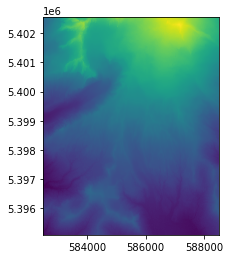

In [6]:
import matplotlib.pyplot as plt
# import rasterio
# from rasterio.plot import show

%matplotlib inline

dem.show()

In [7]:
from icepyx import icesat2data as ipd
import numpy as np
import gdal

import glob



something here

In [ ]:
# query datasets
short_name = 'ATL06'
date_range = ['2018-10-14','2020-04-04']

#Baker DEM
bbox = [-121.87893182746436, 48.70258466806347, -121.79542720391288, 48.7704252035505] #[lonmin,latmin,lonmax,latmax]
epsg = 32610 # projection

# Earthdata Login user name and associated email
earthdata_uid = 'jhsttshj'
email = 'wz278@cornell.edu'

region = ipd.Icesat2Data(short_name, bbox, date_range)
region.earthdata_login(earthdata_uid, email)

# a = np.random.rand(100, 100)
# print(a)

In [ ]:
region.download_granules('/home/jovyan/Workbench/ICESat-2_Baker')


In [ ]:
# !ls ~/Workbench/ICESat-2_Baker

# Get list of files to plot
files = glob.glob('/home/jovyan/Workbench/ICESat-2_Baker/*.h5')
# print(files)

# Variables we want to plot
vnames = ['x', 'y', 'h_li']

# List with one dataframe per file
dfs = [dd.from_array(atl06_lib.read_h5(f, vnames), columns=vnames) for f in files]

# Single parallel dataframe (larger than memory)
df = dd.concat(dfs)

print('Number of files:', len(files))
print('Number of points:', len(df))
#print(df.head())

# dask dataframe convert to pandas dataframe
ddf = df.compute()

In [ ]:
plt.imshow(a)